# Practica 3
## Detección de contornos

Primer paso a tomar es importar las librerías necesarias para poder trabajar

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### TAREA 1: 
Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



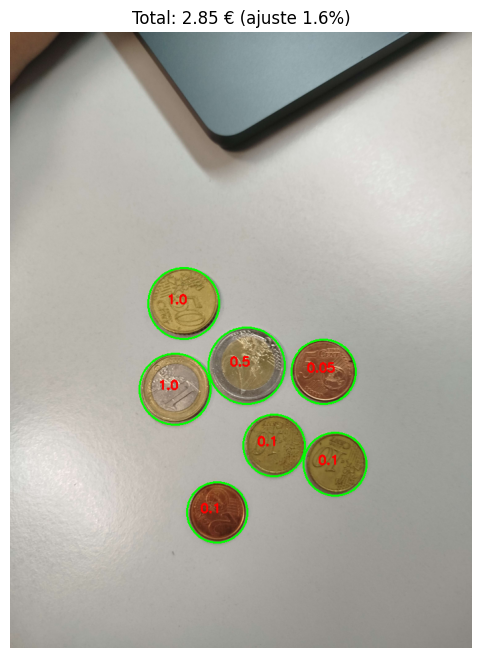

In [24]:
# --- Cargar imagen ---
img = cv2.imread('monedas_no_ideal.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref_point = []

# --- Selección de moneda de referencia ---
def select_coin(event, x, y, flags, param):
    global ref_point
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_point = [(x, y)]
        cv2.circle(img, (x, y), 15, (255, 0, 0), 2)
        cv2.imshow("Selecciona moneda de referencia", img)

cv2.imshow("Selecciona moneda de referencia", img)
cv2.setMouseCallback("Selecciona moneda de referencia", select_coin)
cv2.waitKey(0)
cv2.destroyAllWindows()

# --- Preprocesado: gris + umbral ---
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# --- Encontrar contornos ---
contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Identificar moneda de referencia ---
ref_x, ref_y = ref_point[0]

ref_radius = None
for c in contours:
    (x, y), radius = cv2.minEnclosingCircle(c)
    if np.hypot(x - ref_x, y - ref_y) < radius:
        ref_radius = radius
        break
if ref_radius is None:
    raise ValueError("No se seleccionó correctamente la moneda de referencia.")

# --- Datos de monedas (simplificado) ---
monedas = {
    "1 cent":  {"diametro": 16.25, "valor": 0.01},
    "2 cent":  {"diametro": 18.75, "valor": 0.02},
    "5 cent":  {"diametro": 21.25, "valor": 0.05},
    "10 cent": {"diametro": 19.75, "valor": 0.10},
    "20 cent": {"diametro": 22.25, "valor": 0.20},
    "50 cent": {"diametro": 24.25, "valor": 0.50},
    "1 euro":  {"diametro": 23.25, "valor": 1.00},
    "2 euro":  {"diametro": 25.75, "valor": 2.00}
}

# --- Escala px -> mm ---
px_to_mm = monedas["1 euro"]["diametro"] / (ref_radius * 2)

coin_data = []
errores = []

# --- Filtrar y clasificar contornos ---
for c in contours:
    area = cv2.contourArea(c)
    if area < 100:  # descartar ruido muy pequeño
        continue
    (x, y), radius = cv2.minEnclosingCircle(c)
    diameter_mm = radius * 2 * px_to_mm

    # Buscar moneda más parecida según diámetro
    moneda = min(monedas, key=lambda k: abs(monedas[k]["diametro"] - diameter_mm) / monedas[k]["diametro"])
    error_rel = abs(diameter_mm - monedas[moneda]["diametro"]) / monedas[moneda]["diametro"]

    if abs(error_rel) > 0.05:
        continue

    errores.append(error_rel)
    valor = monedas[moneda]["valor"]
    coin_data.append({'center':(int(x), int(y)), 'value': valor, 'name': moneda})
    cv2.circle(img_rgb, (int(x), int(y)), int(radius), (0, 255, 0), 2)

# --- Ajuste iterativo de la escala según el error medio ---
if errores:
    media_error = np.mean(errores)
    px_to_mm *= (1 - media_error)
else:
    media_error = 0

# --- Recalcular diámetros y valores con escala ajustada ---
total_value = 0
for coin in coin_data:
    x, y = coin['center']
    diameter_mm = 2 * (radius * px_to_mm)
    cv2.putText(img_rgb, f"{coin['value']}", (x-25, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    total_value += coin['value']

# --- Visualización final ---
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Total: {total_value:.2f} € (ajuste {media_error*100:.1f}%)")
plt.show()


### Tarea 2:
El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

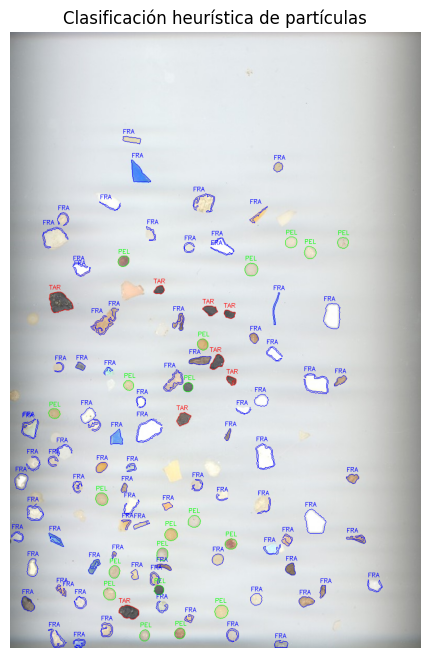

In [ ]:
# --- Archivos ---
image = "MPs_test.jpg"

# --- Carga imagen original ---
imgorig = cv2.imread(image)
img_gray = cv2.cvtColor(imgorig, cv2.COLOR_BGR2GRAY)
img_smooth = cv2.GaussianBlur(img_gray, (5,5), 0)

# --- Umbral adaptativo ---
th = cv2.adaptiveThreshold(img_smooth, 255, 
                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY, 11, 2)
th_inv = 255 - th  # invertimos para resaltar partículas

# --- Binarización final para contornos ---
_, th_bin = cv2.threshold(th_inv, 120, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(th_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Imagen para dibujar resultados ---
img_clasif = imgorig.copy()

# --- Clasificación heurística ---
for c in contours:
    area = cv2.contourArea(c)
    if area < 50:
        continue

    perim = cv2.arcLength(c, True)
    if perim == 0:
        continue

    x, y, w, h = cv2.boundingRect(c)
    circularity = 4 * np.pi * area / (perim ** 2)
    aspecto = w / h if h != 0 else 0

    # --- Color promedio dentro del contorno (original en gris) ---
    mask = np.zeros(img_gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [c], -1, 255, -1)
    mean_val = cv2.mean(img_gray, mask=mask)[0]  # 0-255, 0=negro

    # --- Reglas heurísticas refinadas ---
    if circularity > 0.85:  #para PEL.png 0.005 para el resto 0.85
        clase = "PEL"   # Partículas circulares
        color = (0, 255, 0)
    elif mean_val < 125 and aspecto > 0.9: # para TAR.png 125, 0.7 para 125, FRA.png 80, 0.9 y para MPs_test 125, 0.9
        clase = "TAR"   # Partículas negras y alargadas
        color = (0, 0, 255)
    else:
        clase = "FRA"   # Fragmentos restantes
        color = (255, 0, 0)

    # --- Dibujar contorno y etiqueta ---
    cv2.drawContours(img_clasif, [c], -1, color, 1)
    cv2.putText(img_clasif, clase, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

# --- Visualización ---
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_clasif, cv2.COLOR_BGR2RGB))
plt.title('Clasificación heurística de partículas')
plt.axis('off')
plt.show()


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.